# A simple RBC model in sequence space

In this notebook we showcase the general workflow of setting up and solving dynamic general equilibrium models in sequence space. The process is the exactly the same for heterogeneous-agent models, once the HA blocks are specified.

The notebook accompanies the working paper by Auclert, Bardóczy, Rognlie, Straub (2019): "Using the Sequence-Space Jacobian to Solve and Estimate Heterogeneous-Agent Models". Please see the [Github repository](https://github.com/shade-econ/sequence-jacobian) for more information and code.

## Model description

Let's take a standard RBC model with the following equilibrium conditions.

$$
\textbf{H}_t(\textbf{U}, Z) \equiv 
\begin{pmatrix}
C_t^{-\sigma} - \beta (1 + r_{t+1}) C_{t+1}^{-\sigma}
\\
w_t - \varphi L_t^{\nu} C_t^{\sigma}
\\
K_t - (1 - \delta) K_{t-1} - I_t
\\
r_t + \delta -\alpha Z_t \left(\frac{K_{t-1}}{L_t} \right)^{\alpha-1}
\\
w_t - (1-\alpha) Z_t \left(\frac{K_{t-1}}{L_t} \right)^{\alpha}
\\
Y_t - Z_t K_{t-1}^\alpha L_t^{1-\alpha}
\\
Y_t - C_t - I_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\end{pmatrix},
\qquad t = 0, 1, \dots 
\tag{1}
$$

As usual, labor market clearing is imposed implicitly and asset market clearing is omitted by Walras's law.

## 0 Import packages
The first two are standard python packages, the rest contain code we wrote for this project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import utils
from simple_block import simple
import jacobian as jac
import nonlinear

## 1 Steady state

The first step of solving a model is to compute its steady state. We achieve this in general by writing a function that takes in parameters and calibration targets and returns a dict(ionary) of steady state values. 

In this simple case, the steady state is fully analytical. We choose the discount rate $\beta$ to hit a given real interest rate $r$, the disutility of labor $\varphi$ to hit labor $L=1$, and normalize TFP $Z$ to get output $Y=1$. As a sanity check, we compute the error in Walras's law, residual of HH budget constraint, i.e. capital market clearing.

In [2]:
def rbc_ss(r=0.01, eis=1, frisch=1, delta=0.025, alpha=0.11):
    """Solve steady state of simple RBC model.
        
    Parameters
    ----------
    r      : scalar, real interest rate
    eis    : scalar, elasticity of intertemporal substitution (1/sigma)
    frisch : scalar, Frisch elasticity (1/nu)
    delta  : scalar, depreciation rate
    alpha  : scalar, capital share

    Returns
    -------
    ss : dict, steady state values
    """
    # solve for aggregates analytically
    rk = r + delta
    Z = (rk / alpha) ** alpha  # normalize so that Y=1
    K = (alpha * Z / rk) ** (1 / (1 - alpha))
    Y = Z * K ** alpha
    w = (1 - alpha) * Z * K ** alpha
    I = delta * K
    C = Y - I
    
    # preference params
    beta = 1 / (1 + r)
    vphi = w * C ** (-1 / eis)
    
    # check Walras's law
    walras = C - r * K - w
    assert np.abs(walras) < 1E-12

    return {'beta': beta, 'eis': eis, 'frisch':frisch, 'vphi': vphi, 'delta': delta, 'alpha': alpha,
            'Z': Z, 'K': K, 'I': I, 'Y': Y, 'L': 1, 'C': C, 'w': w, 'r': r, 'walras': walras}

Let's run this function to get the steady state for the default parameters.

In [3]:
ss = rbc_ss()
print(ss)

{'beta': 0.9900990099009901, 'eis': 1, 'frisch': 1, 'vphi': 0.9658914728682173, 'delta': 0.025, 'alpha': 0.11, 'Z': 0.8816460975214567, 'K': 3.1428571428571432, 'I': 0.07857142857142858, 'Y': 1.0, 'L': 1, 'C': 0.9214285714285714, 'w': 0.8900000000000001, 'r': 0.01, 'walras': -2.220446049250313e-16}


## 2 Model blocks

The second step of solving the model is to come up with a Directed Acyclic Graph (DAG) representation for it and specify its building blocks.

The 7 equations of the model can be organized as three simple blocks to form a Directed Acyclic Graph (DAG) in two unknowns $\{K, L\}$ and two targets, the euler equation and goods market clearing:

![Directed Acyclic Graph for RBC model](figures/rbc_dag.png) 


In our code, simple blocks are specified as regular Python functions  endowed with the decorator ``@simple``. In the body of the function, we directly implement the corresponding equilibrium conditions. The decorator turns the function into an instance of ``SimpleBlock``, a class that, among other things, knows how to handle time displacements such as `K(-1)` to denote 1-period lags and `r(+1)` to denote 1-period leads. In general, one can write (-s) and (+s) to denote s-period lags and leads. 

In [5]:
@simple
def firm(K, L, Z, alpha, delta):
    r = alpha * Z * (K(-1) / L) ** (alpha-1) - delta
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y = Z * K(-1) ** alpha * L ** (1 - alpha)
    return r, w, Y

@simple
def household(K, L, w, eis, frisch, vphi, delta):
    C = (w / vphi / L ** (1 / frisch)) ** eis
    I = K - (1 - delta) * K(-1)
    return C, I

@simple
def mkt_clearing(r, C, Y, I, K, L, w, eis, beta):
    goods_mkt = Y - C - I
    euler = C ** (-1 / eis) - beta * (1 + r(+1)) * C(+1) ** (-1 / eis)
    walras = C + K - (1 + r) * K(-1) - w * L  # we can the check dynamic version too
    return goods_mkt, euler, walras

Note that we imported the decorator from the module `simple_model.py`. If you're interested in the inner workings of the SimpleBlock class, check it out.

## 3 Linearized solution

The linearized impulse responses of the model are fully characterized by the general equilibrium Jacobians $G$. These matrices map *any* sequence of shocks into an impulse response, e.g. $dC = G^{C,Z} dZ.$ Once we have them, we're pretty much done!

We can get all of these in a single call to the function `jacobian.get_G`. This function takes in the model blocks (in arbitrary order), the names of exogenous shocks, the names of unknown endogenous variables, the names of target equations, the truncation horizon, and the steady state dict.

In [6]:
G = jac.get_G(block_list=[firm, household, mkt_clearing],
              exogenous=['Z'],
              unknowns=['K', 'L'],
              targets=['euler', 'goods_mkt'],
              T=300, ss=ss)

To see the $G$ matrices in action, let's construct two sequences of TFP shocks. First, a usual autoregressive shock that hits in period 0 (when the economy is assumed to be in steady state). Second, a news shock that, as agents learn in period 0, will hit TFP in period 10 and then decay at a constant rate. Note that such a news shock would be very costly to formulate recursively.

We store the two sequences as columns of a matrix $dZ.$ Let the shock on impact be 1% of steady state productivity, and the  quarterly autocorrelation be 0.8. 

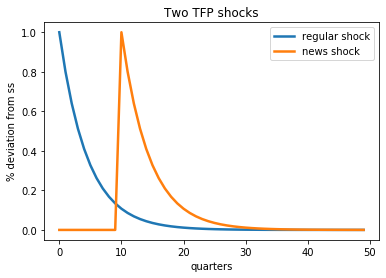

In [7]:
T, impact, rho, news = 300, 0.01, 0.8, 10
dZ = np.empty((T, 2))
dZ[:, 0] = impact * ss['Z'] * rho**np.arange(T)
dZ[:, 1] = np.concatenate((np.zeros(news), dZ[:-news, 0])) 

plt.plot(100*dZ[:50, 0]/ss['Z'], label='regular shock', linewidth=2.5)
plt.plot(100*dZ[:50, 1]/ss['Z'], label='news shock', linewidth=2.5)
plt.title(r'Two TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.legend()
plt.show()

Just apply the $G$ matrix to map these into impulses responses for, say, consumption. We multiply by 100 and divide by $C_{ss}$ just to get the answer in units of % deviations from steady state.

In [14]:
dC = 100 * G['C']['Z'] @ dZ / ss['C']

Now plot the result.

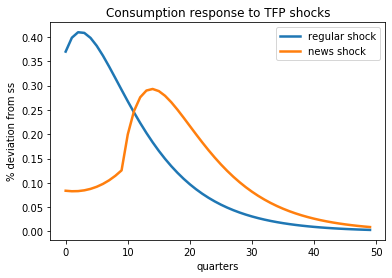

In [15]:
plt.plot(dC[:50, 0], label='regular shock', linewidth=2.5)
plt.plot(dC[:50, 1], label='news shock', linewidth=2.5)
plt.legend()
plt.title(r'Consumption response to TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

For those of you familiar with Dynare, these impulse responses are identical to what you could obtain by running the perfect foresight solver `simul` with the `linear_approximation` option.

## 4 Nonlinear solution

To obtain nonlinear impulse responses that capture the different scale and sign effects of shocks, we use `nonlinear.td_solve`. Similarly to `get_G` above, it takes in the steady state dict, the model blocks (in arbitrary order), the names of unknown endogenous variables and the names of target equations.

However, the names of the exogenous variables would not be sufficient, since we're calculating the nonlinear response to a specific shock. Instead, `td_solve` takes the *sequences* for any exogenous variables that are shocked.

So for the news shock above, we can just call: 

In [9]:
td_nonlin = nonlinear.td_solve(ss=ss, 
                               block_list=[firm, household, mkt_clearing],
                               unknowns=['K', 'L'],
                               targets=['goods_mkt', 'euler'],
                               Z=ss['Z']+dZ[:, 1])

On iteration 0
   max error for goods_mkt is 7.86E-04
   max error for euler is 1.04E-02
On iteration 1
   max error for goods_mkt is 6.75E-05
   max error for euler is 6.68E-05
On iteration 2
   max error for goods_mkt is 1.27E-07
   max error for euler is 3.85E-07
On iteration 3
   max error for goods_mkt is 1.47E-09
   max error for euler is 3.60E-09


As we can see, the linearized solution is very accurate in this case.

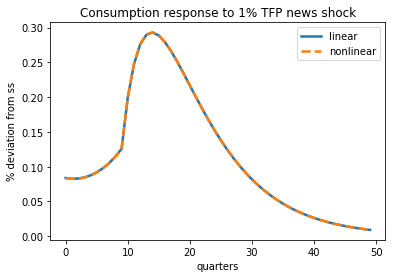

In [10]:
dC_nonlin = 100 * (td_nonlin['C']/ss['C'] - 1)

plt.plot(dC[:50, 1], label='linear', linewidth=2.5)
plt.plot(dC_nonlin[:50], label='nonlinear',  linestyle='--', linewidth=2.5)
plt.title(r'Consumption response to 1% TFP news shock')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.legend()
plt.show()

For those of you familiar with Dynare, these impulse responses are identical to what you could obtain by running the perfect foresight solver `simul`.